### Sparse Softmax Operator
This is an example of how to create and tune a sparse softmax operator.

In [1]:
import torch
import matplotlib.pyplot as plt
import sparta

First, determine the height (batch size) and width (dimensions) of the input tensor and create a dense softmax operator.

In [2]:
H, W = 3072, 4096
dense_softmax = torch.nn.Softmax(dim=-1)

Then generate a mask with block size $32\times32$, in which 80% of blocks are empty. 

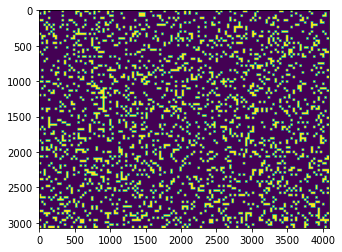

In [3]:
mask = sparta.testing.block_mask((H, W), block=(32, 32), sparsity=0.8).cuda()
plt.imshow(mask.cpu().numpy())

Create a ```sparta.nn.SparseSoftmax``` operator using the dense operator and the mask.

Next, tune the sparse operator using a sample input (to determine the shape). This step may take several minutes.

In [4]:
x = torch.rand((H, W)).cuda()
sparse_softmax = sparta.nn.SparseSoftmax(dense_softmax, mask=mask)
sparta.nn.tune(sparse_softmax, sample_inputs=[x])

[2022-09-13 00:31:42] Grid initialized, size: (1×5×3×4) = 60
==================== Tuning ====================
#0: {'b4841e14': {'_name': 'sparta', 'BLOCK_SIZE_H_VALUE': 8, 'BLOCK_SIZE_W_VALUE': 32, 'ROW_TILE_VALUE': 2}}
Latency: 0.377219 ms
#1: {'b4841e14': {'_name': 'sparta', 'BLOCK_SIZE_H_VALUE': 8, 'BLOCK_SIZE_W_VALUE': 32, 'ROW_TILE_VALUE': 4}}
Latency: 0.38289 ms
#2: {'b4841e14': {'_name': 'sparta', 'BLOCK_SIZE_H_VALUE': 8, 'BLOCK_SIZE_W_VALUE': 32, 'ROW_TILE_VALUE': 8}}
Invalid config
#3: {'b4841e14': {'_name': 'sparta', 'BLOCK_SIZE_H_VALUE': 8, 'BLOCK_SIZE_W_VALUE': 32, 'ROW_TILE_VALUE': 16}}
Invalid config
#4: {'b4841e14': {'_name': 'sparta', 'BLOCK_SIZE_H_VALUE': 8, 'BLOCK_SIZE_W_VALUE': 64, 'ROW_TILE_VALUE': 2}}
Latency: 0.422573 ms
#5: {'b4841e14': {'_name': 'sparta', 'BLOCK_SIZE_H_VALUE': 8, 'BLOCK_SIZE_W_VALUE': 64, 'ROW_TILE_VALUE': 4}}
Latency: 0.430995 ms
#6: {'b4841e14': {'_name': 'sparta', 'BLOCK_SIZE_H_VALUE': 8, 'BLOCK_SIZE_W_VALUE': 64, 'ROW_TILE_VALUE': 8}}
Invali

Check whether the sparse operator works correctly.

In [5]:
torch.testing.assert_close(
    sparse_softmax(x),
    sparta.testing.sparse_softmax_reference(x, mask)
)

The sparse softmax operator is ready to use. Let's compare it with the dense operator.

In [6]:
dense_latency = sparta.testing.test_latency(dense_softmax, inputs=[x])
print(f'Dense linear operator latency: {dense_latency} ms')
sparse_latency = sparta.testing.test_latency(sparse_softmax, inputs=[x])
print(f'Sparse linear operator latency: {sparse_latency} ms')

Dense linear operator latency: 0.49373297119140624 ms
Sparse linear operator latency: 0.378778076171875 ms
